## The data block API

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.basics import *
np.random.seed(42)

The data block API lets you customize the creation of a [`DataBunch`](/basic_data.html#DataBunch) by isolating the underlying parts of that process in separate blocks, mainly:
  1. Where are the inputs and how to create them?
  1. How to split the data into a training and validation sets?
  1. How to label the inputs?
  1. What transforms to apply?
  1. How to add a test set?
  1. How to wrap in dataloaders and create the [`DataBunch`](/basic_data.html#DataBunch)?
  
Each of these may be addressed with a specific block designed for your unique setup. Your inputs might be in a folder, a csv file, or a dataframe. You may want to split them randomly, by certain indices or depending on the folder they are in. You can have your labels in your csv file or your dataframe, but it may come from folders or a specific function of the input. You may choose to add data augmentation or not. A test set is optional too. Finally you have to set the arguments to put the data together in a [`DataBunch`](/basic_data.html#DataBunch) (batch size, collate function...)

The data block API is called as such because you can mix and match each one of those blocks with the others, allowing for a total flexibility to create your customized [`DataBunch`](/basic_data.html#DataBunch) for training, validation and testing. The factory methods of the various [`DataBunch`](/basic_data.html#DataBunch) are great for beginners but you can't always make your data fit in the tracks they require.

<img src="imgs/mix_match.png" alt="Mix and match" width="200">

As usual, we'll begin with end-to-end examples, then switch to the details of each of those parts.

## Examples of use

Let's begin with our traditional MNIST example.

In [ ]:
from fastai.vision import *

In [ ]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/valid')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/3'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/7')]

In [`vision.data`](/vision.data.html#vision.data), we can create a [`DataBunch`](/basic_data.html#DataBunch) suitable for image classification by simply typing:

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=64)

This is a shortcut method which is aimed at data that is in folders following an ImageNet style, with the [`train`](/train.html#train) and `valid` directories, each containing one subdirectory per class, where all the labelled pictures are. There is also a `test` directory containing unlabelled pictures. 

Here is the same code, but this time using the data block API, which can work with any style of a dataset. All the stages, which will be explained below, can be grouped together like this:

In [ ]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

Now we can look at the created DataBunch:

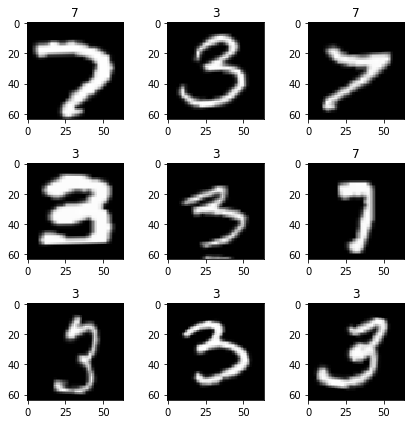

In [ ]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

Let's look at another example from [`vision.data`](/vision.data.html#vision.data) with the planet dataset. This time, it's a multiclassification problem with the labels in a csv file and no given split between valid and train data, so we use a random split. The factory method is:

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
pd.read_csv(planet/"labels.csv").head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [ ]:
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', label_delim = ' ', ds_tfms=planet_tfms)

With the data block API we can rewrite this like that:

In [ ]:
planet.ls()

[PosixPath('/home/ubuntu/.fastai/data/planet_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/planet_tiny/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/planet_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/planet_tiny/models')]

In [ ]:
pd.read_csv(planet/"labels.csv").head()

,image_name,tags
0,train_31112,clear primary
1,train_4300,partly_cloudy primary water
2,train_39539,clear primary water
3,train_12498,agriculture clear primary road
4,train_9320,clear primary


In [ ]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(label_delim=' ')
        #How to label? -> use the second column of the csv file and split the tags by ' '
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

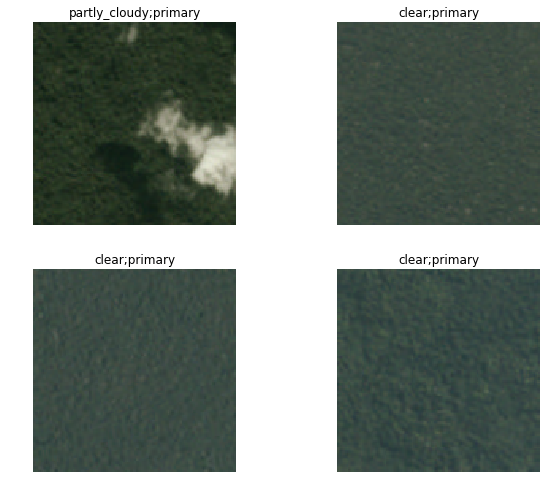

In [ ]:
data.show_batch(rows=2, figsize=(9,7))

The data block API also allows you to get your data together in problems for which there is no direct [`ImageDataBunch`](/vision.data.html#ImageDataBunch) factory method. For a segmentation task, for instance, we can use it to quickly get a [`DataBunch`](/basic_data.html#DataBunch). Let's take the example of the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/). The images are in an 'images' folder and their corresponding mask is in a 'labels' folder.

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We have a file that gives us the names of the classes (what each code inside the masks corresponds to: a pedestrian, a tree, a road...)

In [ ]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

And we define the following function that infers the mask filename from the image filename.

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Then we can easily define a [`DataBunch`](/basic_data.html#DataBunch) using the data block API. Here we need to use `tfm_y=True` in the transform call because we need the same transforms to be applied to the target mask as were applied to the image. Side note: For further control over which transformations are used on the target, each transformation has a `use_on_y` parameter

In [ ]:
data = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_rand_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=128)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch())
        #Finally -> use the defaults for conversion to databunch

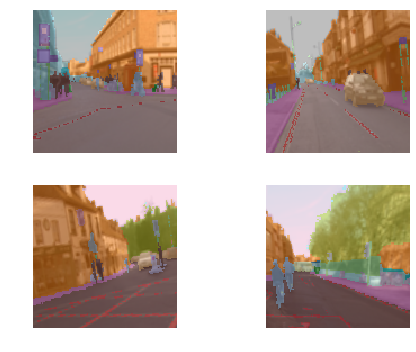

In [ ]:
data.show_batch(rows=2, figsize=(7,5))

Another example for object detection. We use our tiny sample of the [COCO dataset](http://cocodataset.org/#home) here. There is a helper function in the library that reads the annotation file and returns the list of images names with the list of labelled bboxes associated to it. We convert it to a dictionary that maps image names with their bboxes and then write the function that will give us the target for each image filename.

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

The following code is very similar to what we saw before. The only new addition is the use of a special function to collate the samples in batches. This comes from the fact that our images may have multiple bounding boxes, so we need to pad them to the largest number of bounding boxes.

In [ ]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

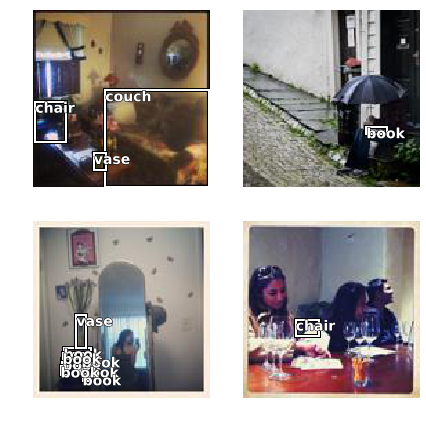

In [ ]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

But vision isn't the only application where the data block API works. It can also be used for text and tabular data. With our sample of the IMDB dataset (labelled texts in a csv file), here is how to get the data together for a language model.

In [ ]:
from fastai.text import *

In [ ]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [ ]:
data_lm = (TextList
           .from_csv(imdb, 'texts.csv', cols='text')
           #Where are the text? Column 'text' of texts.csv
           .split_by_rand_pct()
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch())
           #Finally we convert to a DataBunch

In [ ]:
data_lm.show_batch()

idx,text
0,"! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk ! xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is"
1,", co - billed with xxup the xxup xxunk xxup vampire . a xxmaj spanish - xxmaj italian co - production where a series of women in a village are being murdered around the same time a local count named xxmaj yanos xxmaj xxunk is seen on xxunk , riding off with his ' man - eating ' dog behind him . \n \n xxmaj the xxunk already suspect"
2,"sad relic that is well worth seeing . xxbos i caught this on the dish last night . i liked the movie . i xxunk to xxmaj russia 3 different times ( xxunk our 2 kids ) . i ca n't put my finger on exactly why i liked this movie other than seeing "" bad "" turn "" good "" and "" good "" turn "" semi - bad"
3,"pushed him along . xxmaj the story ( if it can be called that ) is so full of holes it 's almost funny , xxmaj it never really explains why the hell he survived in the first place , or needs human flesh in order to survive . xxmaj the script is poorly written and the dialogue xxunk on just plane stupid . xxmaj the climax to movie ("
4,"the xxunk of the xxmaj xxunk xxmaj race and had the xxunk of some of those racist xxunk . xxmaj fortunately , nothing happened like the incident in the movie where the young xxmaj caucasian man went off and started shooting at a xxunk gathering . \n \n i can only hope and pray that nothing like that ever will happen . \n \n xxmaj so is """


For a classification problem, we just have to change the way labeling is done. Here we use the csv column `label`.

In [ ]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch())

In [ ]:
data_clas.show_batch()

text,target
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the screwed - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many neglect that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


Lastly, for tabular data, we just have to pass the name of our categorical and continuous variables as an extra argument. We also add some [`PreProcessor`](/data_block.html#PreProcessor)s that are going to be applied to our data once the splitting and labelling is done.

In [ ]:
from fastai.tabular import *

In [ ]:
adult = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult/'adult.csv')
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
cont_names = ['education-num', 'hours-per-week', 'age', 'capital-loss', 'fnlwgt', 'capital-gain']
procs = [FillMissing, Categorify, Normalize]

In [ ]:
data = (TabularList.from_df(df, path=adult, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(valid_idx=range(800,1000))
                           .label_from_df(cols=dep_var)
                           .databunch())

In [ ]:
data.show_batch()

workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,education-num,hours-per-week,age,capital-loss,fnlwgt,capital-gain,target
?,Doctorate,Married-civ-spouse,?,Husband,Amer-Indian-Eskimo,Male,United-States,False,2.3157,-0.0356,1.7161,-0.2164,-1.1496,-0.1459,>=50k
Private,Some-college,Never-married,Sales,Own-child,White,Male,United-States,False,-0.0312,-0.4406,-1.4357,-0.2164,-0.1893,-0.1459,<50k
Private,Some-college,Never-married,Protective-serv,Own-child,White,Male,United-States,False,-0.0312,-2.0606,-1.2891,-0.2164,1.1154,-0.1459,<50k
Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Wife,White,Female,Mexico,False,-0.4224,-0.0356,-0.7027,-0.2164,0.0779,-0.1459,>=50k
Private,HS-grad,Married-civ-spouse,Tech-support,Husband,White,Male,United-States,False,-0.4224,3.2043,-0.1163,-0.2164,-0.6858,-0.1459,>=50k


## Step 1: Provide inputs

The basic class to get your inputs into is the following one. It's also the same class that will contain all of your labels (hence the name [`ItemList`](/data_block.html#ItemList)).

In [ ]:
show_doc(ItemList, title_level=3)

<h3 id="ItemList" class="doc_header"><code>class</code> <code>ItemList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L57" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>ItemList</code>(**`items`**:`Iterator`\[`T_co`\], **`path`**:`PathOrStr`=***`'.'`***, **`label_cls`**:`Callable`=***`None`***, **`inner_df`**:`Any`=***`None`***, **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **`x`**:`ItemList`=***`None`***, **`ignore_empty`**:`bool`=***`False`***)

<div class="collapse" id="ItemList-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>ItemList</code>:</p><p>Some other tests where <code>ItemList</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_category</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L9" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L80" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_non_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L91" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_filter_by_folder</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L152" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_multi_category</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L51" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_regression</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L125" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_split_subsets</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L112" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_splitdata_datasets</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L103" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

A collection of items with `__len__` and `__getitem__` with `ndarray` indexing semantics.  

This class regroups the inputs for our model in `items` and saves a `path` attribute which is where it will look for any files (image files, csv file with labels...). `label_cls` will be called to create the labels from the result of the label function, `inner_df` is an underlying dataframe, and `processor` is to be applied to the inputs after the splitting and labeling.

It has multiple subclasses depending on the type of data you're handling. Here is a quick list:
  - [`CategoryList`](/data_block.html#CategoryList) for labels in classification
  - [`MultiCategoryList`](/data_block.html#MultiCategoryList) for labels in a multi classification problem
  - [`FloatList`](/data_block.html#FloatList) for float labels in a regression problem
  - [`ImageList`](/vision.data.html#ImageList) for data that are images
  - [`SegmentationItemList`](/vision.data.html#SegmentationItemList) like [`ImageList`](/vision.data.html#ImageList) but will default labels to [`SegmentationLabelList`](/vision.data.html#SegmentationLabelList)
  - [`SegmentationLabelList`](/vision.data.html#SegmentationLabelList) for segmentation masks
  - [`ObjectItemList`](/vision.data.html#ObjectItemList) like [`ImageList`](/vision.data.html#ImageList) but will default labels to `ObjectLabelList`
  - `ObjectLabelList` for object detection
  - [`PointsItemList`](/vision.data.html#PointsItemList) for points (of the type [`ImagePoints`](/vision.image.html#ImagePoints))
  - [`ImageImageList`](/vision.data.html#ImageImageList) for image to image tasks
  - [`TextList`](/text.data.html#TextList) for text data
  - [`TextList`](/text.data.html#TextList) for text data stored in files
  - [`TabularList`](/tabular.data.html#TabularList) for tabular data
  - [`CollabList`](/collab.html#CollabList) for collaborative filtering

We can get a little glimpse of how [`ItemList`](/data_block.html#ItemList)'s basic attributes and methods behave with the following code examples.

In [ ]:
from fastai.vision import *
path_data = untar_data(URLs.MNIST_TINY)
il_data = ItemList.from_folder(path_data, extensions=['.csv'])
il_data

ItemList (2 items)
/home/ubuntu/.fastai/data/mnist_tiny/labels.csv,/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv
Path: /home/ubuntu/.fastai/data/mnist_tiny

Here is how to access the path of [`ItemList`](/data_block.html#ItemList) and the actual `items` (here files) in the path.

In [ ]:
il_data.path

PosixPath('/home/ubuntu/.fastai/data/mnist_tiny')

In [ ]:
il_data.items

array([PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
       PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
       PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv')], dtype=object)

`len(il_data)` gives you the count of files inside `il_data` and you can access individual items using index. 

In [ ]:
len(il_data)

3

[`ItemList`](/data_block.html#ItemList) returns a single item with a single index, but returns an [`ItemList`](/data_block.html#ItemList) if given a list of indexes.

In [ ]:
il_data[1]

PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv')

In [ ]:
il_data[:1]

ItemList (1 items)
/home/ubuntu/.fastai/data/mnist_tiny/labels.csv
Path: /home/ubuntu/.fastai/data/mnist_tiny

With `il_data.add` we can perform in_place concatenate another [`ItemList`](/data_block.html#ItemList) object.

In [ ]:
il_data.add(il_data); il_data

ItemList (6 items)
/home/ubuntu/.fastai/data/mnist_tiny/labels.csv,/home/ubuntu/.fastai/data/mnist_tiny/history.csv,/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv,/home/ubuntu/.fastai/data/mnist_tiny/labels.csv,/home/ubuntu/.fastai/data/mnist_tiny/history.csv
Path: /home/ubuntu/.fastai/data/mnist_tiny

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/valid')]

In [ ]:
itemlist = ItemList.from_folder(path_data/'test')
itemlist

ItemList (20 items)
/home/ubuntu/.fastai/data/mnist_tiny/test/1503.png,/home/ubuntu/.fastai/data/mnist_tiny/test/5071.png,/home/ubuntu/.fastai/data/mnist_tiny/test/617.png,/home/ubuntu/.fastai/data/mnist_tiny/test/585.png,/home/ubuntu/.fastai/data/mnist_tiny/test/2032.png
Path: /home/ubuntu/.fastai/data/mnist_tiny/test

As we can see, the files do not necesarily return in alpha-numeric order by default. In the above: 1503.png, ... 617.png, 585.png ...

This is OK when you're always using the same machine, as the same dataset should return in the same order. But when building a datablock on one machine (say GCP) and then porting the same code to a different machine (say your laptop) that same dataset and code might return the files in a different order.

Since all random operations use the loaded order of the dataset as the starting point, you will not be able to replicate any random operations, say randomly splitting the data into 80% train, and 20% validation, even while correctly seeding.

The solution is to use `presort=True` in the `.from_folder()` method. As can be seen below, with that argument turned on, the file return in ascending order, and this behavior will match across machines and across platforms. Now you can reproduce any random operation you perfrom on the loaded data.

In [ ]:
itemlist = ItemList.from_folder(path_data/'test', presort=True)
itemlist

ItemList (20 items)
/home/user/.fastai/data/mnist_tiny/test/1503.png,/home/user/.fastai/data/mnist_tiny/test/1605.png,/home/user/.fastai/data/mnist_tiny/test/1883.png,/home/user/.fastai/data/mnist_tiny/test/2032.png,/home/user/.fastai/data/mnist_tiny/test/205.png
Path: /home/user/.fastai/data/mnist_tiny/test

How does such output above is generated?

behind the scenes, executing `itemlist` calls [`ItemList.__repr__`](/data_block.html#ItemList.__repr__) which basically prints out `itemlist[0]` to `itemlist[4]`

In [ ]:
itemlist[0]

PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test/1503.png')

and `itemlist[0]` basically calls `itemlist.get(0)` which returns `itemlist.items[0]`. That's why we have outputs like above.

Once you have selected the class that is suitable, you can instantiate it with one of the following factory methods

In [ ]:
show_doc(ItemList.from_folder)

<h4 id="ItemList.from_folder" class="doc_header"><code>from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L123" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-from_folder-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>from_folder</code>(**`path`**:`PathOrStr`, **`extensions`**:`StrList`=***`None`***, **`recurse`**:`bool`=***`True`***, **`include`**:`OptStrList`=***`None`***, **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **`presort`**:`Optional`\[`bool`\]=***`False`***, **\*\*`kwargs`**) → `ItemList`

<div class="collapse" id="ItemList-from_folder-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-from_folder-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>from_folder</code>:</p><p>Some other tests where <code>from_folder</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_wrong_order</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L132" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the filenames that have a suffix in `extensions`. [`recurse`](/core.html#recurse) determines if we search subfolders. 

In [ ]:
path = untar_data(URLs.MNIST_TINY)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/valid')]

In [ ]:
ImageList.from_folder(path)

ImageList (1428 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_tiny

`path` is your root data folder. In the `path` directory you have _train_ and _valid_ folders which would contain your images. For the below example, _train_ folder contains two folders/classes _cat_ and _dog_.

<img src="imgs/from_folder.png" alt="from_folder">

In [ ]:
show_doc(ItemList.from_df)

<h4 id="ItemList.from_df" class="doc_header"><code>from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L131" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-from_df-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>from_df</code>(**`df`**:`DataFrame`, **`path`**:`PathOrStr`=***`'.'`***, **`cols`**:`IntsOrStrs`=***`0`***, **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **\*\*`kwargs`**) → `ItemList`

<div class="collapse" id="ItemList-from_df-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-from_df-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>from_df</code>:</p><p>Some other tests where <code>from_df</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_category</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L9" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L80" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_non_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L91" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_multi_category</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L51" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_regression</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L125" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the inputs in the `cols` of `df`.  

Dataframe has 2 columns. The first column is the path to the image and the second column contains label id for that image. In case you have multi-labels (i.e more than one label for a single image), you will have a space(as determined by `label_delim` argument of `label_from_df`) seperated string in the labels column.

`from_df` and `from_csv` can be used in a more general way. In cases you are not able to figure out how to get your ImageList, it is very easy to make a csv file with the above format.

How to set `path`? `path` refers to your root data directory. So the paths in your csv file should be relative to `path` and not absolute paths. In the below example, in _labels.csv_ the paths to the images are __path + train/3/7463.png__

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/item_list.txt'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/trained_model.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/valid')]

In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
ImageList.from_df(df, path)

ImageList (14434 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample

In [ ]:
show_doc(ItemList.from_csv)

<h4 id="ItemList.from_csv" class="doc_header"><code>from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L139" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-from_csv-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>from_csv</code>(**`path`**:`PathOrStr`, **`csv_name`**:`str`, **`cols`**:`IntsOrStrs`=***`0`***, **`delimiter`**:`str`=***`None`***, **`header`**:`str`=***`'infer'`***, **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **\*\*`kwargs`**) → `ItemList`

<div class="collapse" id="ItemList-from_csv-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-from_csv-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>from_csv</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the inputs in the `cols` of `path/csv_name`  

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_sample/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/item_list.txt'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/trained_model.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_sample/valid')]

In [ ]:
ImageList.from_csv(path, 'labels.csv')

ImageList (14434 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample

### Optional step: filter your data

The factory method may have grabbed too many items. For instance, if you were searching sub folders with the `from_folder` method, you may have gotten files you don't want. To remove those, you can use one of the following methods.

In [ ]:
show_doc(ItemList.filter_by_func)

<h4 id="ItemList.filter_by_func" class="doc_header"><code>filter_by_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L160" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-filter_by_func-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>filter_by_func</code>(**`func`**:`Callable`) → `ItemList`

<div class="collapse" id="ItemList-filter_by_func-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-filter_by_func-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>filter_by_func</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Only keep elements for which `func` returns `True`.  

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


Suppose that you only want to keep images with a suffix ".png". Well, this method will do magic for you.

In [ ]:
Path(df.name[0]).suffix

'.png'

In [ ]:
ImageList.from_df(df, path).filter_by_func(lambda fname: Path(fname).suffix == '.png')

ImageList (14434 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample

In [ ]:
show_doc(ItemList.filter_by_folder)

<h4 id="ItemList.filter_by_folder" class="doc_header"><code>filter_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L165" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-filter_by_folder-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>filter_by_folder</code>(**`include`**=***`None`***, **`exclude`**=***`None`***)

<div class="collapse" id="ItemList-filter_by_folder-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-filter_by_folder-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>filter_by_folder</code>:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_filter_by_folder</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L152" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Only keep filenames in `include` folder or reject the ones in `exclude`.  

In [ ]:
show_doc(ItemList.filter_by_rand)

<h4 id="ItemList.filter_by_rand" class="doc_header"><code>filter_by_rand</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L176" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-filter_by_rand-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>filter_by_rand</code>(**`p`**:`float`, **`seed`**:`int`=***`None`***)

<div class="collapse" id="ItemList-filter_by_rand-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-filter_by_rand-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>filter_by_rand</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Keep random sample of `items` with probability `p` and an optional `seed`.  

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
ImageList.from_folder(path).filter_by_rand(0.5)

ImageList (7267 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample

Contrast the number of items with the list created without the filter.

In [ ]:
ImageList.from_folder(path)

ImageList (14434 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample

In [ ]:
show_doc(ItemList.to_text)

<h4 id="ItemList.to_text" class="doc_header"><code>to_text</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L156" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-to_text-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>to_text</code>(**`fn`**:`str`)

<div class="collapse" id="ItemList-to_text-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-to_text-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>to_text</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Save `self.items` to `fn` in `self.path`.  

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
pd.read_csv(path/'labels.csv').head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
file_name = "item_list.txt"
ImageList.from_folder(path).to_text(file_name)

In [ ]:
! cat {path/file_name} | head

train/3/5736.png
train/3/35272.png
train/3/26596.png
train/3/42120.png
train/3/39675.png
train/3/47881.png
train/3/38241.png
train/3/59054.png
train/3/9932.png
train/3/50184.png
cat: write error: Broken pipe


In [ ]:
show_doc(ItemList.use_partial_data)

<h4 id="ItemList.use_partial_data" class="doc_header"><code>use_partial_data</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L149" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-use_partial_data-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>use_partial_data</code>(**`sample_pct`**:`float`=***`0.01`***, **`seed`**:`int`=***`None`***) → `ItemList`

<div class="collapse" id="ItemList-use_partial_data-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-use_partial_data-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>use_partial_data</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Use only a sample of `sample_pct`of the full dataset and an optional `seed`.  

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
ImageList.from_folder(path).use_partial_data(0.5)

ImageList (7217 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample

Contrast the number of items with the list created without the filter.

In [ ]:
ImageList.from_folder(path)

ImageList (14434 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample

### Writing your own [`ItemList`](/data_block.html#ItemList)

First check if you can't easily customize one of the existing subclass by:
- subclassing an existing one and replacing the `get` method (or the `open` method if you're dealing with images)
- applying a custom `processor` (see step 4)
- changing the default `label_cls` for the label creation
- adding a default [`PreProcessor`](/data_block.html#PreProcessor) with the `_processor` class variable

If this isn't the case and you really need to write your own class, there is a [full tutorial](/tutorial.itemlist) that explains how to proceed.

In [ ]:
show_doc(ItemList.analyze_pred)

<h4 id="ItemList.analyze_pred" class="doc_header"><code>analyze_pred</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L95" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-analyze_pred-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>analyze_pred</code>(**`pred`**:`Tensor`)

<div class="collapse" id="ItemList-analyze_pred-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-analyze_pred-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>analyze_pred</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called on `pred` before `reconstruct` for additional preprocessing.  

In [ ]:
show_doc(ItemList.get)

<h4 id="ItemList.get" class="doc_header"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L74" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-get-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get</code>(**`i`**) → `Any`

<div class="collapse" id="ItemList-get-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-get-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Subclass if you want to customize how to create item `i` from `self.items`.  

We will have a glimpse of how `get` work with the following demo. 

In [ ]:
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/valid')]

In [ ]:
il_data_base = ItemList.from_folder(path=path_data, extensions=['.png'], include=['test'])
il_data_base

ItemList (20 items)
/home/ubuntu/.fastai/data/mnist_tiny/test/1503.png,/home/ubuntu/.fastai/data/mnist_tiny/test/5071.png,/home/ubuntu/.fastai/data/mnist_tiny/test/617.png,/home/ubuntu/.fastai/data/mnist_tiny/test/585.png,/home/ubuntu/.fastai/data/mnist_tiny/test/2032.png
Path: /home/ubuntu/.fastai/data/mnist_tiny

`get` is used inexplicitly within `il_data_base[15]`. `il_data_base.get(15)` gives the same result here, because its defulat it's to return that.

In [ ]:
il_data_base[15]

PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test/6736.png')

While creating your custom [`ItemList`](/data_block.html#ItemList) however, you can override this function to do some things to your item (like opening an image).

In [ ]:
il_data_image = ImageList.from_folder(path=path_data, extensions=['.png'], include=['test'])
il_data_image

ImageList (20 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_tiny

Again, normally `get` is used inexplicitly within `il_data_image[15]`.

In [ ]:
il_data_image[15]

The reason why an image is printed out instead of a FilePath object, is [`ImageList.get`](/vision.data.html#ImageList.get) overwrites [`ItemList.get`](/data_block.html#ItemList.get) and use [`ImageList.open`](/vision.data.html#ImageList.open) to print an image.

In [ ]:
show_doc(ItemList.new)

<h4 id="ItemList.new" class="doc_header"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L103" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-new-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>new</code>(**`items`**:`Iterator`\[`T_co`\], **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **\*\*`kwargs`**) → `ItemList`

<div class="collapse" id="ItemList-new-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-new-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>new</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a new [`ItemList`](/data_block.html#ItemList) from `items`, keeping the same attributes.  

You'll never need to subclass this normally, just don't forget to add to `self.copy_new` the names of the arguments that needs to be copied each time `new` is called in `__init__`.

We will get a feel of how `new` works with the following examples.

In [ ]:
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/valid')]

In [ ]:
itemlist1 = ItemList.from_folder(path=path_data/'valid', extensions=['.png'])
itemlist1

ItemList (699 items)
/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7692.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7484.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9157.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/8703.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9182.png
Path: /home/ubuntu/.fastai/data/mnist_tiny/valid

As you will see below, `copy_new` allows use to borrow any argument and its value from `itemlist1`, and `itemlist1.new(itemlist1.items)` allows us to use `items` and arguments inside `copy_new` to create another [`ItemList`](/data_block.html#ItemList) by calling [`ItemList.__init__`](/data_block.html#ItemList.__init__).

In [ ]:
itemlist1.copy_new == ['x', 'label_cls', 'path']

True

In [ ]:
((itemlist1.x == itemlist1.label_cls == itemlist1.inner_df == None) 
 and (itemlist1.path == Path('/Users/Natsume/.fastai/data/mnist_tiny/valid')))


False

You can select any argument from [`ItemList.__init__`](/data_block.html#ItemList.__init__)'s signature and change their values. 

In [ ]:
itemlist1.copy_new = ['x', 'label_cls', 'path', 'inner_df']
itemlist1.x = itemlist1.label_cls = itemlist1.path = itemlist1.inner_df = 'test'
itemlist2 = itemlist1.new(items=itemlist1.items)

In [ ]:
(itemlist2.inner_df == itemlist2.x == itemlist2.label_cls == 'test' 
and itemlist2.path == Path('test'))

True

In [ ]:
show_doc(ItemList.reconstruct)

<h4 id="ItemList.reconstruct" class="doc_header"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L99" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-reconstruct-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>reconstruct</code>(**`t`**:`Tensor`, **`x`**:`Tensor`=***`None`***)

<div class="collapse" id="ItemList-reconstruct-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-reconstruct-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>reconstruct</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Reconstruct one of the underlying item for its data `t`.  

## Step 2: Split the data between the training and the validation set

This step is normally straightforward, you just have to pick one of the following functions depending on what you need.

In [ ]:
show_doc(ItemList.split_none)

<h4 id="ItemList.split_none" class="doc_header"><code>split_none</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L185" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_none-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_none</code>()

<div class="collapse" id="ItemList-split_none-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_none-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>split_none</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Don't split the data and create an empty validation set.  

In [ ]:
show_doc(ItemList.split_by_rand_pct)

<h4 id="ItemList.split_by_rand_pct" class="doc_header"><code>split_by_rand_pct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L217" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_by_rand_pct-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_by_rand_pct</code>(**`valid_pct`**:`float`=***`0.2`***, **`seed`**:`int`=***`None`***) → `ItemLists`

<div class="collapse" id="ItemList-split_by_rand_pct-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_by_rand_pct-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>split_by_rand_pct</code>:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_splitdata_datasets</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L103" class="source_link" style="float:right">[source]</a></li></ul><p>Some other tests where <code>split_by_rand_pct</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_regression</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L125" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Split the items randomly by putting `valid_pct` in the validation set, optional `seed` can be passed.  

In [ ]:
show_doc(ItemList.split_subsets)

<h4 id="ItemList.split_subsets" class="doc_header"><code>split_subsets</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L225" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_subsets-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_subsets</code>(**`train_size`**:`float`, **`valid_size`**:`float`, **`seed`**=***`None`***) → `ItemLists`

<div class="collapse" id="ItemList-split_subsets-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_subsets-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>split_subsets</code>:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_split_subsets</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L112" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Split the items into train set with size `train_size * n` and valid set with size `valid_size * n`.  

This function is handy if you want to work with subsets of specific sizes, e.g., you want to use 20% of the data for the validation dataset, but you only want to train on a small subset of the rest of the data: `split_subsets(train_size=0.08, valid_size=0.2)`.

In [ ]:
show_doc(ItemList.split_by_files)

<h4 id="ItemList.split_by_files" class="doc_header"><code>split_by_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L241" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_by_files-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_by_files</code>(**`valid_names`**:`ItemList`) → `ItemLists`

<div class="collapse" id="ItemList-split_by_files-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_by_files-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>split_by_files</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Split the data by using the names in `valid_names` for validation.  

In [ ]:
show_doc(ItemList.split_by_fname_file)

<h4 id="ItemList.split_by_fname_file" class="doc_header"><code>split_by_fname_file</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L246" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_by_fname_file-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_by_fname_file</code>(**`fname`**:`PathOrStr`, **`path`**:`PathOrStr`=***`None`***) → `ItemLists`

<div class="collapse" id="ItemList-split_by_fname_file-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_by_fname_file-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>split_by_fname_file</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Split the data by using the names in `fname` for the validation set. `path` will override `self.path`.  

Internally makes a call to `split_by_files`. `fname` contains your image file names like 0001.png.

In [ ]:
show_doc(ItemList.split_by_folder)

<h4 id="ItemList.split_by_folder" class="doc_header"><code>split_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L209" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_by_folder-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_by_folder</code>(**`train`**:`str`=***`'train'`***, **`valid`**:`str`=***`'valid'`***) → `ItemLists`

<div class="collapse" id="ItemList-split_by_folder-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_by_folder-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>split_by_folder</code>:</p><p>Some other tests where <code>split_by_folder</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_wrong_order</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L132" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Split the data depending on the folder (`train` or `valid`) in which the filenames are.  

In [ ]:
jekyll_note("This method looks at the folder immediately after `self.path` for `valid` and `train`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the folder immediately after `self.path` for `valid` and `train`.</div>

Basically, `split_by_folder` takes in two folder names ('train' and 'valid' in the following example), to split `il` the large [`ImageList`](/vision.data.html#ImageList) into two smaller [`ImageList`](/vision.data.html#ImageList)s, one for training set and the other for validation set. Both [`ImageList`](/vision.data.html#ImageList)s are attached to a large [`ItemLists`](/data_block.html#ItemLists) which is the final output of `split_by_folder`.

In [ ]:
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/export.pkl'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/models'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/valid')]

In [ ]:
il = ItemList.from_folder(path=path_data); il

ItemList (1439 items)
/home/ubuntu/.fastai/data/mnist_tiny/labels.csv,/home/ubuntu/.fastai/data/mnist_tiny/export.pkl,/home/ubuntu/.fastai/data/mnist_tiny/history.csv,/home/ubuntu/.fastai/data/mnist_tiny/cleaned.csv,/home/ubuntu/.fastai/data/mnist_tiny/test/1503.png
Path: /home/ubuntu/.fastai/data/mnist_tiny

In [ ]:
sd = il.split_by_folder(train='train', valid='valid'); sd

ItemLists;

Train: ItemList (713 items)
/home/ubuntu/.fastai/data/mnist_tiny/train/export.pkl,/home/ubuntu/.fastai/data/mnist_tiny/train/3/9932.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/7189.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/8498.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/8888.png
Path: /home/ubuntu/.fastai/data/mnist_tiny;

Valid: ItemList (699 items)
/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7692.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7484.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9157.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/8703.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9182.png
Path: /home/ubuntu/.fastai/data/mnist_tiny;

Test: None

Behind the scenes, `split_by_folder` uses `_get_by_folder(name)`, to turn both 'train' and 'valid' folders into two list of indexes, and pass them onto `split_by_idxs` to split `il` into two [`ImageList`](/vision.data.html#ImageList)s, and finally attached to a [`ItemLists`](/data_block.html#ItemLists). 

In [ ]:
train_idx = il._get_by_folder(name='train')
train_idx[:5], train_idx[-5:], len(train_idx)

([24, 25, 26, 27, 28], [732, 733, 734, 735, 736], 713)

In [ ]:
valid_idx = il._get_by_folder(name='valid') 
valid_idx[:5], valid_idx[-5:],len(valid_idx)

([740, 741, 742, 743, 744], [1434, 1435, 1436, 1437, 1438], 699)

By the way, `_get_by_folder(name)` works in the following way, first, index the entire `il.items`, loop every item and if an item belongs to the named folder, e.g., 'train', then put it into a list. The folder `name` is the only input, and output is the list.

In [ ]:
show_doc(ItemList.split_by_idx)

<h4 id="ItemList.split_by_idx" class="doc_header"><code>split_by_idx</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L199" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_by_idx-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_by_idx</code>(**`valid_idx`**:`Collection`\[`int`\]) → `ItemLists`

<div class="collapse" id="ItemList-split_by_idx-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_by_idx-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>split_by_idx</code>:</p><p>Some other tests where <code>split_by_idx</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_category</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L9" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L80" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_non_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L91" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_multi_category</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L51" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Split the data according to the indexes in `valid_idx`.  

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


You can pass a list of indices that you want to put in the validation set like [1, 3, 10]. Or you can pass a contiguous list like `list(range(1000))`

In [ ]:
data = (ImageList.from_df(df, path)
                 .split_by_idx(list(range(1000))))
data

ItemLists;

Train: ImageList (13434 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample;

Valid: ImageList (1000 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample;

Test: None

In [ ]:
show_doc(ItemList.split_by_idxs)

<h4 id="ItemList.split_by_idxs" class="doc_header"><code>split_by_idxs</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L195" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_by_idxs-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_by_idxs</code>(**`train_idx`**, **`valid_idx`**)

<div class="collapse" id="ItemList-split_by_idxs-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_by_idxs-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>split_by_idxs</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Split the data between `train_idx` and `valid_idx`.  

Behind the scenes, `split_by_idxs` turns two index lists (`train_idx` and `valid_idx`) into two [`ImageList`](/vision.data.html#ImageList)s, and then pass onto `split_by_list` to split `il` into two [`ImageList`](/vision.data.html#ImageList)s and attach to a [`ItemLists`](/data_block.html#ItemLists).

In [ ]:
sd = il.split_by_idxs(train_idx=train_idx, valid_idx=valid_idx); sd

ItemLists;

Train: ItemList (713 items)
/home/ubuntu/.fastai/data/mnist_tiny/train/export.pkl,/home/ubuntu/.fastai/data/mnist_tiny/train/3/9932.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/7189.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/8498.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/8888.png
Path: /home/ubuntu/.fastai/data/mnist_tiny;

Valid: ItemList (699 items)
/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7692.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7484.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9157.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/8703.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9182.png
Path: /home/ubuntu/.fastai/data/mnist_tiny;

Test: None

In [ ]:
show_doc(ItemList.split_by_list)

<h4 id="ItemList.split_by_list" class="doc_header"><code>split_by_list</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L191" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_by_list-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_by_list</code>(**`train`**, **`valid`**)

<div class="collapse" id="ItemList-split_by_list-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_by_list-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>split_by_list</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Split the data between `train` and `valid`.  

`split_by_list` takes in two [`ImageList`](/vision.data.html#ImageList)s which in the case below are `il[train_idx]` and `il[valid_idx]`, and pass them onto `_split` ([`ItemLists`](/data_block.html#ItemLists)) to initialize an [`ItemLists`](/data_block.html#ItemLists) object, which basically takes in the training, valiation and testing (optionally) [`ImageList`](/vision.data.html#ImageList)s as its properties.

In [ ]:
sd = il.split_by_list(train=il[train_idx], valid=il[valid_idx]); sd

ItemLists;

Train: ItemList (713 items)
/home/ubuntu/.fastai/data/mnist_tiny/train/export.pkl,/home/ubuntu/.fastai/data/mnist_tiny/train/3/9932.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/7189.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/8498.png,/home/ubuntu/.fastai/data/mnist_tiny/train/3/8888.png
Path: /home/ubuntu/.fastai/data/mnist_tiny;

Valid: ItemList (699 items)
/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7692.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/7484.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9157.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/8703.png,/home/ubuntu/.fastai/data/mnist_tiny/valid/3/9182.png
Path: /home/ubuntu/.fastai/data/mnist_tiny;

Test: None

This is more of an internal method, you should be using `split_by_files` if you want to pass a list of filenames for the validation set.

In [ ]:
show_doc(ItemList.split_by_valid_func)

<h4 id="ItemList.split_by_valid_func" class="doc_header"><code>split_by_valid_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L236" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_by_valid_func-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_by_valid_func</code>(**`func`**:`Callable`) → `ItemLists`

<div class="collapse" id="ItemList-split_by_valid_func-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_by_valid_func-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>split_by_valid_func</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Split the data by result of `func` (which returns `True` for validation set).  

In [ ]:
show_doc(ItemList.split_from_df)

<h4 id="ItemList.split_from_df" class="doc_header"><code>split_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L252" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-split_from_df-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>split_from_df</code>(**`col`**:`IntsOrStrs`=***`2`***)

<div class="collapse" id="ItemList-split_from_df-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-split_from_df-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>split_from_df</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Split the data from the `col` in the dataframe in `self.inner_df`.  

To use this function, you need a boolean column `is_valid`. If `is_valid[index] = True`, then that example is put in the validation set and if `is_valid[index] = False` the example is put in the training set.

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
df = pd.read_csv(path/'labels.csv')

# Create a new column for is_valid
df['is_valid'] = [True]*(df.shape[0]//2) + [False]*(df.shape[0]//2)

# Randomly shuffle dataframe
df = df.reindex(np.random.permutation(df.index))
print(df.shape)
df.head()

(14434, 3)


,name,label,is_valid
2071,train/3/28571.png,0,True
9382,train/7/24434.png,1,False
6399,train/7/56604.png,1,True
130,train/3/4740.png,0,True
9226,train/7/18876.png,1,False


In [ ]:
data = (ImageList.from_df(df, path)
                 .split_from_df())
data

ItemLists;

Train: ImageList (7217 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample;

Valid: ImageList (7217 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /home/ubuntu/.fastai/data/mnist_sample;

Test: None

In [ ]:
jekyll_warn("This method assumes the data has been created from a csv file or a dataframe.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>This method assumes the data has been created from a csv file or a dataframe.</div>

## Step 3: Label the inputs

To label your inputs, use one of the following functions. Note that even if it's not in the documented arguments, you can always pass a `label_cls` that will be used to create those labels (the default is the one from your input [`ItemList`](/data_block.html#ItemList), and if there is none, it will go to [`CategoryList`](/data_block.html#CategoryList),  [`MultiCategoryList`](/data_block.html#MultiCategoryList) or [`FloatList`](/data_block.html#FloatList) depending on the type of the labels). This is implemented in the following function:

In [ ]:
show_doc(ItemList.get_label_cls)

<h4 id="ItemList.get_label_cls" class="doc_header"><code>get_label_cls</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L257" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-get_label_cls-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get_label_cls</code>(**`labels`**, **`label_cls`**:`Callable`=***`None`***, **`label_delim`**:`str`=***`None`***, **\*\*`kwargs`**)

<div class="collapse" id="ItemList-get_label_cls-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-get_label_cls-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get_label_cls</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Return `label_cls` or guess one from the first element of `labels`.  

Behind the scenes, [`ItemList.get_label_cls`](/data_block.html#ItemList.get_label_cls) basically select a label class according to the item type of `labels`, whereas `labels` can be any of `Collection`, `pandas.core.frame.DataFrame`, `pandas.core.series.Series`. If the list elements are of type string or integer, `get_label_cls` will output [`CategoryList`](/data_block.html#CategoryList); they are of type float, then it will output [`FloatList`](/data_block.html#FloatList); if they are of type Collection, then it will output `MultiCateogryList`.

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY)
sd = ImageList.from_folder(path_data).split_by_folder('train', 'valid'); sd

ItemLists;

Train: ImageList (709 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Valid: ImageList (699 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Test: None

In [ ]:
labels = ['7', '3']
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.CategoryList

In [ ]:
labels = [7, 3]
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.CategoryList

In [ ]:
labels = [7.0, 3.0]
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.FloatList

In [ ]:
labels = [[7, 3],]
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.MultiCategoryList

In [ ]:
labels = [['7', '3'],]
label_cls = sd.train.get_label_cls(labels); label_cls

fastai.data_block.MultiCategoryList

If no `label_cls` argument is passed, the correct labeling type can usually be inferred based on the data (for classification or regression). If you have multiple regression targets (e.g. predict 5 different numbers from a single image/text), be aware that arrays of floats are by default considered to be targets for one-hot encoded classification. If your task is regression, be sure the pass `label_cls = FloatList` so that learners created from your databunch initialize correctly.

The first example in these docs created labels as follows:

In [ ]:
path = untar_data(URLs.MNIST_TINY)
ll = ImageList.from_folder(path).split_by_folder().label_from_folder().train

If you want to save the data necessary to recreate your [`LabelList`](/data_block.html#LabelList) (not including saving the actual image/text/etc files), you can use `to_df` or `to_csv`:

```python
ll.train.to_csv('tmp.csv')
```

Or just grab a `pd.DataFrame` directly:

In [ ]:
ll.to_df().head()

,x,y
0,train/7/9243.png,7
1,train/7/9519.png,7
2,train/7/7534.png,7
3,train/7/9082.png,7
4,train/7/8377.png,7


In [ ]:
show_doc(ItemList.label_empty)

<h4 id="ItemList.label_empty" class="doc_header"><code>label_empty</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L291" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-label_empty-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>label_empty</code>(**\*\*`kwargs`**)

<div class="collapse" id="ItemList-label_empty-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-label_empty-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>label_empty</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Label every item with an [`EmptyLabel`](/core.html#EmptyLabel).  

In [ ]:
show_doc(ItemList.label_from_df)

<h4 id="ItemList.label_from_df" class="doc_header"><code>label_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L278" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-label_from_df-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>label_from_df</code>(**`cols`**:`IntsOrStrs`=***`1`***, **`label_cls`**:`Callable`=***`None`***, **\*\*`kwargs`**)

<div class="collapse" id="ItemList-label_from_df-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-label_from_df-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>label_from_df</code>:</p><p>Some other tests where <code>label_from_df</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_category</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L9" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L80" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_non_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L91" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_multi_category</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L51" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_regression</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L125" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Label `self.items` from the values in `cols` in `self.inner_df`.  

In [ ]:
jekyll_warn("This method only works with data objects created with either `from_csv` or `from_df` methods.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>This method only works with data objects created with either `from_csv` or `from_df` methods.</div>

In [ ]:
show_doc(ItemList.label_const)

<h4 id="ItemList.label_const" class="doc_header"><code>label_const</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L287" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-label_const-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>label_const</code>(**`const`**:`Any`=***`0`***, **`label_cls`**:`Callable`=***`None`***, **\*\*`kwargs`**) → `LabelList`

<div class="collapse" id="ItemList-label_const-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-label_const-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>label_const</code>:</p><p>Some other tests where <code>label_const</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_split_subsets</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L112" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_splitdata_datasets</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L103" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Label every item with `const`.  

In [ ]:
show_doc(ItemList.label_from_folder)

<h4 id="ItemList.label_from_folder" class="doc_header"><code>label_from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L300" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-label_from_folder-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>label_from_folder</code>(**`label_cls`**:`Callable`=***`None`***, **\*\*`kwargs`**) → `LabelList`

<div class="collapse" id="ItemList-label_from_folder-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-label_from_folder-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>label_from_folder</code>:</p><ul><li><code>pytest -sv tests/test_text_data.py::test_filter_classes</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_text_data.py#L42" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_text_data.py::test_from_folder</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_text_data.py#L30" class="source_link" style="float:right">[source]</a></li></ul><p>Some other tests where <code>label_from_folder</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_wrong_order</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L132" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Give a label to each filename depending on its folder.  

In [ ]:
jekyll_note("This method looks at the last subfolder in the path to determine the classes.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the last subfolder in the path to determine the classes.</div>

Behind the scenes, when an [`ItemList`](/data_block.html#ItemList) calls `label_from_folder`, it creates a lambda function which outputs a foldername which a file Path object immediately or directly belongs to, and then calls `label_from_func` with the lambda function as input. 

On the practical and high level, `label_from_folder` is mostly used with [`ItemLists`](/data_block.html#ItemLists) rather than [`ItemList`](/data_block.html#ItemList) for simplicity and efficiency, for details see the `label_from_folder` example on [ItemLists](). Even when you just want a training set [`ItemList`](/data_block.html#ItemList), you still need to do `split_none` to create an [`ItemLists`](/data_block.html#ItemLists) and then do labeling with `label_from_folder`, as the example shown below.

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/valid'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/models'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/train')]

In [ ]:
sd_train = ImageList.from_folder(path_data/'train').split_none()
ll_train = sd_train.label_from_folder(); ll_train

LabelLists;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Test: None

In [ ]:
show_doc(ItemList.label_from_func)

<h4 id="ItemList.label_from_func" class="doc_header"><code>label_from_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L296" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-label_from_func-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>label_from_func</code>(**`func`**:`Callable`, **`label_cls`**:`Callable`=***`None`***, **\*\*`kwargs`**) → `LabelList`

<div class="collapse" id="ItemList-label_from_func-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-label_from_func-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>label_from_func</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Apply `func` to every input to get its label.  

Inside `label_from_func`, it applies the input `func` to every item of an [`ItemList`](/data_block.html#ItemList) and puts all the function outputs into a list, and then passes the list onto [`ItemList._label_from_list`](/data_block.html#ItemList._label_from_list). Below is a simple example of using `label_from_func`.

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY)
sd = ImageList.from_folder(path_data).split_by_folder('train', 'valid');sd

ItemLists;

Train: ImageList (709 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Valid: ImageList (699 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Test: None

In [ ]:
func=lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2]

The lambda function above is to access the immediate foldername for a file Path object.

In [ ]:
ll = sd.label_from_func(func); ll

LabelLists;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Valid: LabelList (699 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Test: None

In [ ]:
show_doc(ItemList.label_from_re)

<h4 id="ItemList.label_from_re" class="doc_header"><code>label_from_re</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L305" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-label_from_re-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>label_from_re</code>(**`pat`**:`str`, **`full_path`**:`bool`=***`False`***, **`label_cls`**:`Callable`=***`None`***, **\*\*`kwargs`**) → `LabelList`

<div class="collapse" id="ItemList-label_from_re-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-label_from_re-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>label_from_re</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Apply the re in `pat` to determine the label of every filename.  If `full_path`, search in the full name.  

In [ ]:
show_doc(CategoryList, title_level=3)

<h3 id="CategoryList" class="doc_header"><code>class</code> <code>CategoryList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L370" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryList-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>CategoryList</code>(**`items`**:`Iterator`\[`T_co`\], **`classes`**:`Collection`\[`T_co`\]=***`None`***, **`label_delim`**:`str`=***`None`***, **\*\*`kwargs`**) :: [`CategoryListBase`](/data_block.html#CategoryListBase)

<div class="collapse" id="CategoryList-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryList-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>CategoryList</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Basic [`ItemList`](/data_block.html#ItemList) for single classification labels.  

[`ItemList`](/data_block.html#ItemList) suitable for storing labels in `items` belonging to `classes`. If `None` are passed, `classes` will be determined by the unique different labels. `processor` will default to [`CategoryProcessor`](/data_block.html#CategoryProcessor).

[`CategoryList`](/data_block.html#CategoryList) uses `labels` to create an [`ItemList`](/data_block.html#ItemList) for dealing with categorical labels. Behind the scenes, [`CategoryList`](/data_block.html#CategoryList) is a subclass of [`CategoryListBase`](/data_block.html#CategoryListBase) which is a subclass of [`ItemList`](/data_block.html#ItemList). [`CategoryList`](/data_block.html#CategoryList) inherits from [`CategoryListBase`](/data_block.html#CategoryListBase) the properties such as `classes` (default as `None`), `filter_missing_y` (default as `True`), and has its own unique property `loss_func` (default as `CrossEntropyFlat()`), and its own class attribute `_processor` (default as [`CategoryProcessor`](/data_block.html#CategoryProcessor)). 

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY)
ll = ImageList.from_folder(path_data).split_by_folder('train', 'valid').label_from_folder()
ll.train.y.items, ll.train.y.classes, ll.train.y[0]

(array([1, 1, 1, 1, ..., 0, 0, 0, 0]), ['3', '7'], Category 7)

In [ ]:
cl = CategoryList(ll.train.y.items, ll.train.y.classes); cl

CategoryList (709 items)
7,7,7,7,7
Path: .

For the behavior of printing out [`CategoryList`](/data_block.html#CategoryList) object or access an element using index, please see [`CategoryList.get`](/data_block.html#CategoryList.get) below.

Behind the scenes, [`CategoryList.get`](/data_block.html#CategoryList.get) is used inexplicitly when printing out the [`CategoryList`](/data_block.html#CategoryList) object or `cl[idx]`. According to the source of [`CategoryList.get`](/data_block.html#CategoryList.get), each `item` is used to get its own `class`. When 'classes' is a list of strings, then elements of `items` are used as index of a list, therefore they must be integers in the range from 0 to `len(classes)-1`; if `classes` is a dictionary, then elements of `items` are used as keys, therefore they can be strings too. See examples below for details.

In [ ]:
from fastai.vision import *

In [ ]:
items = np.array([0, 1, 2, 1, 0])
cl = CategoryList(items, classes=['3', '7', '9']); cl

CategoryList (5 items)
3,7,9,7,3
Path: .

In [ ]:
items = np.array(['3', '7', '9', '7', '3'])
classes = {'3':3, '7':7, '9':9}
cl = CategoryList(items, classes); cl

CategoryList (5 items)
3,7,9,7,3
Path: .

In [ ]:
show_doc(MultiCategoryList, title_level=3)

<h3 id="MultiCategoryList" class="doc_header"><code>class</code> <code>MultiCategoryList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L407" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#MultiCategoryList-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>MultiCategoryList</code>(**`items`**:`Iterator`\[`T_co`\], **`classes`**:`Collection`\[`T_co`\]=***`None`***, **`label_delim`**:`str`=***`None`***, **`one_hot`**:`bool`=***`False`***, **\*\*`kwargs`**) :: [`CategoryListBase`](/data_block.html#CategoryListBase)

<div class="collapse" id="MultiCategoryList-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#MultiCategoryList-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>MultiCategoryList</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Basic [`ItemList`](/data_block.html#ItemList) for multi-classification labels.  

It will store list of labels in `items` belonging to `classes`. If `None` are passed, `classes` will be determined by the unique different labels. `sep` is used to split the content of `items` in a list of tags.

If `one_hot=True`, the items contain the labels one-hot encoded. In this case, it is mandatory to pass a list of `classes` (as we can't use the different labels).

In [ ]:
show_doc(FloatList, title_level=3)

<h3 id="FloatList" class="doc_header"><code>class</code> <code>FloatList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L433" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#FloatList-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>FloatList</code>(**`items`**:`Iterator`\[`T_co`\], **`log`**:`bool`=***`False`***, **`classes`**:`Collection`\[`T_co`\]=***`None`***, **\*\*`kwargs`**) :: [`ItemList`](/data_block.html#ItemList)

<div class="collapse" id="FloatList-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#FloatList-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>FloatList</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

[`ItemList`](/data_block.html#ItemList) suitable for storing the floats in items for regression. Will add a `log` if this flag is `True`.  

In [ ]:
show_doc(EmptyLabelList, title_level=3)

<h3 id="EmptyLabelList" class="doc_header"><code>class</code> <code>EmptyLabelList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L319" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#EmptyLabelList-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>EmptyLabelList</code>(**`items`**:`Iterator`\[`T_co`\], **`path`**:`PathOrStr`=***`'.'`***, **`label_cls`**:`Callable`=***`None`***, **`inner_df`**:`Any`=***`None`***, **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **`x`**:`ItemList`=***`None`***, **`ignore_empty`**:`bool`=***`False`***) :: [`ItemList`](/data_block.html#ItemList)

<div class="collapse" id="EmptyLabelList-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#EmptyLabelList-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>EmptyLabelList</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Basic [`ItemList`](/data_block.html#ItemList) for dummy labels.  

## Invisible step: preprocessing

This isn't seen here in the API, but if you passed a `processor` (or a list of them) in your initial [`ItemList`](/data_block.html#ItemList) during step 1, it will be applied here. If you didn't pass any processor, a list of them might still be created depending on what is in the `_processor` variable of your class of items (this can be a list of [`PreProcessor`](/data_block.html#PreProcessor) classes).

A processor is a transformation that is applied to all the inputs once at initialization, with a state computed on the training set that is then applied without modification on the validation set (and maybe the test set). For instance, it can be processing texts to tokenize then numericalize them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in tabular data, where we fill missing values with (for instance) the median computed on the training set. That statistic is stored in the inner state of the [`PreProcessor`](/data_block.html#PreProcessor) and applied on the validation set.

This is the generic class for all processors.

In [ ]:
show_doc(PreProcessor, title_level=3)

<h3 id="PreProcessor" class="doc_header"><code>class</code> <code>PreProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L48" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#PreProcessor-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>PreProcessor</code>(**`ds`**:`Collection`\[`T_co`\]=***`None`***)

<div class="collapse" id="PreProcessor-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#PreProcessor-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>PreProcessor</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Basic class for a processor that will be applied to items at the end of the data block API.  

In [ ]:
show_doc(PreProcessor.process_one)

<h4 id="PreProcessor.process_one" class="doc_header"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L51" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#PreProcessor-process_one-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process_one</code>(**`item`**:`Any`)

<div class="collapse" id="PreProcessor-process_one-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#PreProcessor-process_one-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>process_one</code>:</p><p>Some other tests where <code>process_one</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_category_processor_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L80" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_non_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L91" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Process one `item`. This method needs to be written in any subclass.

In [ ]:
show_doc(PreProcessor.process)

<h4 id="PreProcessor.process" class="doc_header"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L52" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#PreProcessor-process-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process</code>(**`ds`**:`Collection`\[`T_co`\])

<div class="collapse" id="PreProcessor-process-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#PreProcessor-process-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>process</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

`ds`: an object of [`ItemList`](/data_block.html#ItemList)       
Process a dataset. This default to apply `process_one` on every `item` of `ds`.

In [ ]:
show_doc(CategoryProcessor, title_level=3)

<h3 id="CategoryProcessor" class="doc_header"><code>class</code> <code>CategoryProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L326" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryProcessor-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>CategoryProcessor</code>(**`ds`**:[`ItemList`](/data_block.html#ItemList)) :: [`PreProcessor`](/data_block.html#PreProcessor)

<div class="collapse" id="CategoryProcessor-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryProcessor-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>CategoryProcessor</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

[`PreProcessor`](/data_block.html#PreProcessor) that create `classes` from `ds.items` and handle the mapping.  

In [ ]:
show_doc(CategoryProcessor.generate_classes)

<h4 id="CategoryProcessor.generate_classes" class="doc_header"><code>generate_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L336" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryProcessor-generate_classes-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>generate_classes</code>(**`items`**)

<div class="collapse" id="CategoryProcessor-generate_classes-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryProcessor-generate_classes-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>generate_classes</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Generate classes from `items` by taking the sorted unique values.  

In [ ]:
show_doc(CategoryProcessor.process)

<h4 id="CategoryProcessor.process" class="doc_header"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L346" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryProcessor-process-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process</code>(**`ds`**)

<div class="collapse" id="CategoryProcessor-process-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryProcessor-process-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>process</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

`ds` is an object of [`CategoryList`](/data_block.html#CategoryList).     
It basically generates a list of unique labels (assigned to `ds.classes`) and a dictionary mapping `classes` to indexes (assigned to `ds.c2i`).

It is an internal function only called to apply processors to training, validation and testing datasets after the labeling step.

In [ ]:
show_doc(MultiCategoryProcessor, title_level=3)

<h3 id="MultiCategoryProcessor" class="doc_header"><code>class</code> <code>MultiCategoryProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L387" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#MultiCategoryProcessor-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>MultiCategoryProcessor</code>(**`ds`**:[`ItemList`](/data_block.html#ItemList), **`one_hot`**:`bool`=***`False`***) :: [`CategoryProcessor`](/data_block.html#CategoryProcessor)

<div class="collapse" id="MultiCategoryProcessor-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#MultiCategoryProcessor-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>MultiCategoryProcessor</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

[`PreProcessor`](/data_block.html#PreProcessor) that create `classes` from `ds.items` and handle the mapping.  

In [ ]:
show_doc(MultiCategoryProcessor.generate_classes)

<h4 id="MultiCategoryProcessor.generate_classes" class="doc_header"><code>generate_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L399" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#MultiCategoryProcessor-generate_classes-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>generate_classes</code>(**`items`**)

<div class="collapse" id="MultiCategoryProcessor-generate_classes-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#MultiCategoryProcessor-generate_classes-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>generate_classes</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Generate classes from `items` by taking the sorted unique values.  

## Optional steps

### Add transforms

Transforms differ from processors in the sense they are applied on the fly when we grab one item. They also may change each time we ask for the same item in the case of random transforms.

In [ ]:
show_doc(LabelLists.transform)

<h4 id="ItemLists.transform" class="doc_header"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L500" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemLists-transform-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>transform</code>(**`tfms`**:`Optional`\[`Tuple`\[`Union`\[`Callable`, `Collection`\[`Callable`\]\], `Union`\[`Callable`, `Collection`\[`Callable`\]\]\]\]=***`(None, None)`***, **\*\*`kwargs`**)

<div class="collapse" id="ItemLists-transform-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemLists-transform-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>transform</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set `tfms` to be applied to the xs of the train and validation set.  

This is primary for the vision application. The `kwargs` arguments are the ones expected by the type of transforms you pass. `tfm_y` is among them and if set to `True`, the transforms will be applied to input and target.

For examples see: [vision.transforms](vision.transform.html).

### Add a test set

To add a test set, you can use one of the two following methods.

In [ ]:
show_doc(LabelLists.add_test)

<h4 id="LabelLists.add_test" class="doc_header"><code>add_test</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L556" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelLists-add_test-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>add_test</code>(**`items`**:`Iterator`\[`T_co`\], **`label`**:`Any`=***`None`***)

<div class="collapse" id="LabelLists-add_test-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelLists-add_test-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>add_test</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Add test set containing `items` with an arbitrary `label`.  

In [ ]:
jekyll_note("Here `items` can be an `ItemList` or a collection.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>Here `items` can be an `ItemList` or a collection.</div>

In [ ]:
show_doc(LabelLists.add_test_folder)

<h4 id="LabelLists.add_test_folder" class="doc_header"><code>add_test_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L566" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelLists-add_test_folder-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>add_test_folder</code>(**`test_folder`**:`str`=***`'test'`***, **`label`**:`Any`=***`None`***)

<div class="collapse" id="LabelLists-add_test_folder-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelLists-add_test_folder-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>add_test_folder</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Add test set containing items from `test_folder` and an arbitrary `label`.  

In [ ]:
jekyll_warn("In fastai the test set is unlabeled! No labels will be collected even if they are available.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>In fastai the test set is unlabeled! No labels will be collected even if they are available.</div>

Instead, either the passed `label` argument or an empty label will be used for all entries of this dataset (this is required by the internal pipeline of fastai). 

In the `fastai` framework `test` datasets have no labels - this is the unknown data to be predicted. If you want to validate your model on a `test` dataset with labels, you probably need to use it as a validation set, as in:

```
data_test = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        ...)
```

Another approach, where you do use a normal validation set, and then when the training is over, you just want to validate the test set w/ labels as a validation set, you can do this:

```
tfms = []
path = Path('data').resolve()
data = (ImageList.from_folder(path)
        .split_by_pct()
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize() ) 
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
learn.fit_one_cycle(5,1e-2)

# now replace the validation dataset entry with the test dataset as a new validation dataset: 
# everything is exactly the same, except replacing `split_by_pct` w/ `split_by_folder` 
# (or perhaps you were already using the latter, so simply switch to valid='test')
data_test = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms)
        .databunch()
        .normalize()
       ) 
learn.validate(data_test.valid_dl)
```
Of course, your data block can be totally different, this is just an example.

## Step 4: convert to a [`DataBunch`](/basic_data.html#DataBunch)

This last step is usually pretty straightforward. You just have to include all the arguments we pass to [`DataBunch.create`](/basic_data.html#DataBunch.create) (`bs`, `num_workers`,  `collate_fn`). The class called to create a [`DataBunch`](/basic_data.html#DataBunch) is set in the `_bunch` attribute of the inputs of the training set if you need to modify it. Normally, the various subclasses we showed before handle that for you.

In [ ]:
show_doc(LabelLists.databunch)

<h4 id="LabelLists.databunch" class="doc_header"><code>databunch</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L543" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelLists-databunch-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>databunch</code>(**`path`**:`PathOrStr`=***`None`***, **`bs`**:`int`=***`64`***, **`val_bs`**:`int`=***`None`***, **`num_workers`**:`int`=***`4`***, **`dl_tfms`**:`Optional`\[`Collection`\[`Callable`\]\]=***`None`***, **`device`**:[`device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device)=***`None`***, **`collate_fn`**:`Callable`=***`'data_collate'`***, **`no_check`**:`bool`=***`False`***, **\*\*`kwargs`**) → `DataBunch`

<div class="collapse" id="LabelLists-databunch-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelLists-databunch-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>databunch</code>:</p><ul><li><code>pytest -sv tests/test_vision_data.py::test_vision_datasets</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_vision_data.py#L217" class="source_link" style="float:right">[source]</a></li></ul><p>Some other tests where <code>databunch</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_regression</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L125" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Create an [`DataBunch`](/basic_data.html#DataBunch) from self, `path` will override `self.path`, `kwargs` are passed to [`DataBunch.create`](/basic_data.html#DataBunch.create).  

## Inner classes

In [ ]:
show_doc(LabelList, title_level=3)

<h3 id="LabelList" class="doc_header"><code>class</code> <code>LabelList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L596" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>LabelList</code>(**`x`**:[`ItemList`](/data_block.html#ItemList), **`y`**:[`ItemList`](/data_block.html#ItemList), **`tfms`**:`Union`\[`Callable`, `Collection`\[`Callable`\]\]=***`None`***, **`tfm_y`**:`bool`=***`False`***, **\*\*`kwargs`**) :: [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

<div class="collapse" id="LabelList-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>LabelList</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

A list of inputs `x` and labels `y` with optional `tfms`.  

Optionally apply `tfms` to `y` if `tfm_y` is `True`. 

Behind the scenes, it takes inputs [`ItemList`](/data_block.html#ItemList) and labels [`ItemList`](/data_block.html#ItemList) as its properties `x` and `y`, sets property `item` to `None`, and uses [`LabelList.transform`](/data_block.html#LabelList.transform) to apply a list of transforms `TfmList` to `x` and `y` if `tfm_y` is set `True`.

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY)
ll = ImageList.from_folder(path_data).split_by_folder('train', 'valid').label_from_folder()
ll.train.x, ll.train.y

(ImageList (709 items)
 Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
 Path: /Users/Natsume/.fastai/data/mnist_tiny, CategoryList (709 items)
 7,7,7,7,7
 Path: /Users/Natsume/.fastai/data/mnist_tiny)

In [ ]:
LabelList(x=ll.train.x, y=ll.train.y)

LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny

In [ ]:
show_doc(LabelList.export)

<h4 id="LabelList.export" class="doc_header"><code>export</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L675" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-export-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>export</code>(**`fn`**:`PathOrStr`, **\*\*`kwargs`**)

<div class="collapse" id="LabelList-export-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-export-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>export</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Export the minimal state and save it in `fn` to load an empty version for inference.  

In [ ]:
show_doc(LabelList.transform_y)

<h4 id="LabelList.transform_y" class="doc_header"><code>transform_y</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L729" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-transform_y-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>transform_y</code>(**`tfms`**:`Union`\[`Callable`, `Collection`\[`Callable`\]\]=***`None`***, **\*\*`kwargs`**)

<div class="collapse" id="LabelList-transform_y-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-transform_y-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>transform_y</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set `tfms` to be applied to the targets only.  

In [ ]:
show_doc(LabelList.get_state)

<h4 id="LabelList.get_state" class="doc_header"><code>get_state</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L666" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-get_state-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get_state</code>(**\*\*`kwargs`**)

<div class="collapse" id="LabelList-get_state-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-get_state-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get_state</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Return the minimal state for export.  

In [ ]:
show_doc(LabelList.load_empty)

<h4 id="LabelList.load_empty" class="doc_header"><code>load_empty</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L679" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-load_empty-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>load_empty</code>(**`path`**:`PathOrStr`, **`fn`**:`PathOrStr`)

<div class="collapse" id="LabelList-load_empty-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-load_empty-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>load_empty</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Load the state in `fn` to create an empty [`LabelList`](/data_block.html#LabelList) for inference.  

In [ ]:
show_doc(LabelList.load_state)

<h4 id="LabelList.load_state" class="doc_header"><code>load_state</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L684" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-load_state-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>load_state</code>(**`path`**:`PathOrStr`, **`state`**:`dict`) → `LabelList`

<div class="collapse" id="LabelList-load_state-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-load_state-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>load_state</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a [`LabelList`](/data_block.html#LabelList) from `state`.  

In [ ]:
show_doc(LabelList.process)

<h4 id="LabelList.process" class="doc_header"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L695" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-process-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process</code>(**`xp`**:[`PreProcessor`](/data_block.html#PreProcessor)=***`None`***, **`yp`**:[`PreProcessor`](/data_block.html#PreProcessor)=***`None`***, **`name`**:`str`=***`None`***)

<div class="collapse" id="LabelList-process-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-process-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>process</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Launch the processing on `self.x` and `self.y` with `xp` and `yp`.  

Behind the scenes, [`LabelList.process`](/data_block.html#LabelList.process) does 3 three things: 1. ask labels `y` to be processed by `yp` with `y.process(yp)`; 2. if `y.filter_missing_y` is `True`, then removes the missing data samples from `x` and `y`; 3. ask inputs `x` to be processed by `xp` with `x.process(xp)`

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY)
sd = ImageList.from_folder(path_data).split_by_folder('train', 'valid')

In [ ]:
sd.train = sd.train.label_from_folder(from_item_lists=True)
sd.valid = sd.valid.label_from_folder(from_item_lists=True)
sd.__class__ = LabelLists

In [ ]:
xp,yp = sd.get_processors()
xp,yp

([], [<fastai.data_block.CategoryProcessor at 0x1a23757a90>])

In [ ]:
sd.train.process(xp, yp)

LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny

In [ ]:
show_doc(LabelList.set_item)

<h4 id="LabelList.set_item" class="doc_header"><code>set_item</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L606" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-set_item-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>set_item</code>(**`item`**)

<div class="collapse" id="LabelList-set_item-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-set_item-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>set_item</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

For inference, will briefly replace the dataset with one that only contains `item`.  

In [ ]:
show_doc(LabelList.to_df)

<h4 id="LabelList.to_df" class="doc_header"><code>to_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L658" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-to_df-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>to_df</code>()

<div class="collapse" id="LabelList-to_df-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-to_df-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>to_df</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create `pd.DataFrame` containing `items` from `self.x` and `self.y`.  

In [ ]:
show_doc(LabelList.to_csv)

<h4 id="LabelList.to_csv" class="doc_header"><code>to_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L662" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-to_csv-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>to_csv</code>(**`dest`**:`str`)

<div class="collapse" id="LabelList-to_csv-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-to_csv-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>to_csv</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Save `self.to_df()` to a CSV file in `self.path`/`dest`.  

In [ ]:
show_doc(LabelList.transform)

<h4 id="LabelList.transform" class="doc_header"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L719" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-transform-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>transform</code>(**`tfms`**:`Union`\[`Callable`, `Collection`\[`Callable`\]\], **`tfm_y`**:`bool`=***`None`***, **\*\*`kwargs`**)

<div class="collapse" id="LabelList-transform-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-transform-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>transform</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set the `tfms` and `tfm_y` value to be applied to the inputs and targets.  

In [ ]:
show_doc(ItemLists, title_level=3)

<h3 id="ItemLists" class="doc_header"><code>class</code> <code>ItemLists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L448" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemLists-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>ItemLists</code>(**`path`**:`PathOrStr`, **`train`**:[`ItemList`](/data_block.html#ItemList), **`valid`**:[`ItemList`](/data_block.html#ItemList))

<div class="collapse" id="ItemLists-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemLists-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>ItemLists</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

An [`ItemList`](/data_block.html#ItemList) for each of `train` and `valid` (optional `test`).  

It initializes an [`ItemLists`](/data_block.html#ItemLists) object, which basically brings in the training, valiation and testing (optionally) [`ItemList`](/data_block.html#ItemList)s as its properties. It also offers helpful warning messages on situations when the training or validation [`ItemList`](/data_block.html#ItemList) is empty. 

See the following example for how to create an [`ItemLists`](/data_block.html#ItemLists) object. 

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/valid'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/models'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/train')]

In [ ]:
il_train = ImageList.from_folder(path_data/'train')
il_valid = ImageList.from_folder(path_data/'valid')
il_test = ImageList.from_folder(path_data/'test')

In [ ]:
ils = ItemLists(path=path_data, train=il_train, valid=il_valid); ils

ItemLists;

Train: ImageList (709 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Valid: ImageList (699 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/valid;

Test: None

In [ ]:
ils.test = il_test; ils

ItemLists;

Train: ImageList (709 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Valid: ImageList (699 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/valid;

Test: ImageList (20 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/test

However, we are most likely to see an [`ItemLists`](/data_block.html#ItemLists), right after a large [`ItemList`](/data_block.html#ItemList) is splitted and turned into an [`ItemLists`](/data_block.html#ItemLists) by methods like [`ItemList.split_by_folder`](/data_block.html#ItemList.split_by_folder). Then, we will add labels to all training and validation simply using `sd.label_from_folder()` (`sd` is an [`ItemLists`](/data_block.html#ItemLists), see example below). Now, some of you may be surprised because `label_from_folder` is a method of [`ItemList`](/data_block.html#ItemList) not [`ItemLists`](/data_block.html#ItemLists). Well, this is a magic of fastai data_block api.

With the following example, we may understand a little better how to get labelling done by calling [`ItemLists.__getattr__`](/data_block.html#ItemLists.__getattr__) with [`ItemList.label_from_folder`](/data_block.html#ItemList.label_from_folder).

In [ ]:
il = ImageList.from_folder(path_data); il

ImageList (1428 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny

An [`ItemList`](/data_block.html#ItemList) or its subclass object must do a split to turn itself into an [`ItemLists`](/data_block.html#ItemLists) before doing labeling to become a [`LabelLists`](/data_block.html#LabelLists) object.

In [ ]:
sd = il.split_by_folder(train='train', valid='valid'); sd


ItemLists;

Train: ImageList (709 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Valid: ImageList (699 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Test: None

In [ ]:
ll = sd.label_from_folder(); ll

LabelLists;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Valid: LabelList (699 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Test: None

Even when there is just an [`ImageList`](/vision.data.html#ImageList) from a traning set folder with no split needed, we still must do `split_none()` in order to create an [`ItemLists`](/data_block.html#ItemLists), and only then we can do `ItemLists.label_from_folder()` nicely.

In [ ]:
il_train = ImageList.from_folder(path_data/'train')
sd_train = il_train.split_none(); sd_train

ItemLists;

Train: ImageList (709 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Valid: ImageList (0 items)

Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Test: None

In [ ]:
ll_valid_empty = sd_train.label_from_folder(); ll_valid_empty

LabelLists;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Test: None

So practially, although `label_from_folder` is not an [`ItemLists`](/data_block.html#ItemLists) method, we can call `ItemLists.label_from_folder()` to label training, validation and test [`ItemList`](/data_block.html#ItemList)s once for all.

Behind the scenes, `ItemLists.label_from_folder()` actually calls `ItemLists.__getattr__('label_from_folder')`, in which all training, validation even testing [`ItemList`](/data_block.html#ItemList) get to call `label_from_folder`, and then turns the [`ItemLists`](/data_block.html#ItemLists) into a [`LabelLists`](/data_block.html#LabelLists) and calls [`LabelLists.process`](/data_block.html#LabelLists.process) at last.

You can directly use `LabelLists.__getattr__` to do labelling as below.

In [ ]:
ld_inner = sd.__getattr__('label_from_folder'); ld_inner()

LabelLists;

Train: LabelList (709 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Valid: LabelList (699 items)
x: ImageList
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /Users/Natsume/.fastai/data/mnist_tiny;

Test: None

In [ ]:
show_doc(ItemLists.label_from_lists)

<h4 id="ItemLists.label_from_lists" class="doc_header"><code>label_from_lists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L491" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemLists-label_from_lists-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>label_from_lists</code>(**`train_labels`**:`Iterator`\[`T_co`\], **`valid_labels`**:`Iterator`\[`T_co`\], **`label_cls`**:`Callable`=***`None`***, **\*\*`kwargs`**) → `LabelList`

<div class="collapse" id="ItemLists-label_from_lists-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemLists-label_from_lists-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>label_from_lists</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Use the labels in `train_labels` and `valid_labels` to label the data. `label_cls` will overwrite the default.  

In [ ]:
show_doc(ItemLists.transform)

<h4 id="ItemLists.transform" class="doc_header"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L500" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemLists-transform-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>transform</code>(**`tfms`**:`Optional`\[`Tuple`\[`Union`\[`Callable`, `Collection`\[`Callable`\]\], `Union`\[`Callable`, `Collection`\[`Callable`\]\]\]\]=***`(None, None)`***, **\*\*`kwargs`**)

<div class="collapse" id="ItemLists-transform-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemLists-transform-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>transform</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set `tfms` to be applied to the xs of the train and validation set.  

In [ ]:
show_doc(ItemLists.transform_y)

<h4 id="ItemLists.transform_y" class="doc_header"><code>transform_y</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L509" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemLists-transform_y-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>transform_y</code>(**`tfms`**:`Optional`\[`Tuple`\[`Union`\[`Callable`, `Collection`\[`Callable`\]\], `Union`\[`Callable`, `Collection`\[`Callable`\]\]\]\]=***`(None, None)`***, **\*\*`kwargs`**)

<div class="collapse" id="ItemLists-transform_y-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemLists-transform_y-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>transform_y</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Set `tfms` to be applied to the ys of the train and validation set.  

In [ ]:
show_doc(LabelLists, title_level=3)

<h3 id="LabelLists" class="doc_header"><code>class</code> <code>LabelLists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L521" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelLists-pytest" style="float:right; padding-right:10px">[test]</a></h3>

> <code>LabelLists</code>(**`path`**:`PathOrStr`, **`train`**:[`ItemList`](/data_block.html#ItemList), **`valid`**:[`ItemList`](/data_block.html#ItemList)) :: [`ItemLists`](/data_block.html#ItemLists)

<div class="collapse" id="LabelLists-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelLists-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>LabelLists</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

A [`LabelList`](/data_block.html#LabelList) for each of `train` and `valid` (optional `test`).  

Creating a [`LabelLists`](/data_block.html#LabelLists) object is exactly the same way as creating an [`ItemLists`](/data_block.html#ItemLists) object, because its base class is [`ItemLists`](/data_block.html#ItemLists) and does not overwrite [`ItemLists.__init__`](/data_block.html#ItemLists.__init__). The example below shows how to build a [`LabelLists`](/data_block.html#LabelLists) object.

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY); path_data.ls()

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/valid'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/models'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/train')]

In [ ]:
il_train = ImageList.from_folder(path_data/'train')
il_valid = ImageList.from_folder(path_data/'valid')

In [ ]:
ll_test = LabelLists(path_data, il_train, il_valid); 
ll_test.test = il_valid = ImageList.from_folder(path_data/'test')
ll_test

LabelLists;

Train: ImageList (709 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/train;

Valid: ImageList (699 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/valid;

Test: ImageList (20 items)
Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28),Image (3, 28, 28)
Path: /Users/Natsume/.fastai/data/mnist_tiny/test

In [ ]:
show_doc(LabelLists.get_processors)

<h4 id="LabelLists.get_processors" class="doc_header"><code>get_processors</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L523" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelLists-get_processors-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get_processors</code>()

<div class="collapse" id="LabelLists-get_processors-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelLists-get_processors-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get_processors</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Read the default class processors if none have been set.  

Behind the scenes, `LabelLists.get_processors()` first puts `train.x._processor` classes and `train.y._processor` classes into separate lists, and then instantiates those processors and put them into `xp` and `yp`.

In [ ]:
from fastai.vision import *

In [ ]:
path_data = untar_data(URLs.MNIST_TINY)
sd = ImageList.from_folder(path_data).split_by_folder('train', 'valid')

In [ ]:
sd.train = sd.train.label_from_folder(from_item_lists=True)
sd.valid = sd.valid.label_from_folder(from_item_lists=True)
sd.__class__ = LabelLists

In [ ]:
xp,yp = sd.get_processors()
xp,yp

In [ ]:
show_doc(LabelLists.load_empty)

<h4 id="LabelLists.load_empty" class="doc_header"><code>load_empty</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L580" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelLists-load_empty-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>load_empty</code>(**`path`**:`PathOrStr`, **`fn`**:`PathOrStr`=***`'export.pkl'`***)

<div class="collapse" id="LabelLists-load_empty-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelLists-load_empty-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>load_empty</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a [`LabelLists`](/data_block.html#LabelLists) with empty sets from the serialized file in `path/fn`.  

In [ ]:
show_doc(LabelLists.load_state)

<h4 id="LabelLists.load_state" class="doc_header"><code>load_state</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L572" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelLists-load_state-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>load_state</code>(**`path`**:`PathOrStr`, **`state`**:`dict`)

<div class="collapse" id="LabelLists-load_state-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelLists-load_state-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>load_state</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a [`LabelLists`](/data_block.html#LabelLists) with empty sets from the serialized `state`.  

In [ ]:
show_doc(LabelLists.process)

<h4 id="LabelLists.process" class="doc_header"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L530" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelLists-process-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process</code>()

<div class="collapse" id="LabelLists-process-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelLists-process-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>process</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Process the inner datasets.  

In [ ]:
show_doc(ItemList.process)

<h4 id="ItemList.process" class="doc_header"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L81" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-process-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process</code>(**`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***)

<div class="collapse" id="ItemList-process-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-process-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>process</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Apply `processor` or `self.processor` to `self`.  

`processor` is one or more `PreProcessors` objects    
Behind the scenes, we put all of `processor` into a list and apply them all to an object of [`ItemList`](/data_block.html#ItemList) or its subclasses.

## Helper functions

In [ ]:
show_doc(get_files)

<h4 id="get_files" class="doc_header"><code>get_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L30" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#get_files-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get_files</code>(**`path`**:`PathOrStr`, **`extensions`**:`StrList`=***`None`***, **`recurse`**:`bool`=***`False`***, **`include`**:`OptStrList`=***`None`***, **`presort`**:`bool`=***`False`***) → `FilePathList`

<div class="collapse" id="get_files-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#get_files-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get_files</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Return list of files in `path` that have a suffix in `extensions`; optionally [`recurse`](/core.html#recurse).  

To to more precise, this function returns list of FilePath objects using files in `path` that must have a suffix in `extensions`, and hidden folders and files are ignored. If `recurse=True`, all files in subfolders will be applied; `include` is used to select particular folders to apply.

Inside [`get_files`](/data_block.html#get_files), there is [`_get_files`](/data_block.html#_get_files) which turns all filenames inside `f` from directory `parent/p` into a list of FilePath objects. All filenames must have a suffix in `extensions`. All hidden files are ignored.

In [ ]:
path_data = untar_data(URLs.MNIST_TINY) 

In [ ]:
path_data.ls()

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/valid'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/models'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/train')]

With `recurse=False`, no subfolder files are made available.

In [ ]:
list_FilePath_noRecurse = get_files(path_data) 
list_FilePath_noRecurse

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/history.csv')]

With `recurse=True`, all subfolder files are made available, except hidden files.

In [ ]:
list_FilePath_recurse = get_files(path_data, recurse=True)
list_FilePath_recurse[:3]

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/valid/7/9294.png')]

In [ ]:
list_FilePath_recurse[-2:]

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/train/3/7263.png'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/train/3/7288.png')]

With `extensions=['.csv']`, only files with the suffix of `.csv` are made available.

In [ ]:
list_FilePath_recurse_csv = get_files(path_data, recurse=True, extensions=['.csv'])
list_FilePath_recurse_csv

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/history.csv')]

With `include=['test']`, only files in `path_data` and its subfolder `test` are made available.

In [ ]:
list_FilePath_include = get_files(path_data, recurse=True, extensions=['.png','.jpg','.jpeg'],
                                  include=['test'])
list_FilePath_include[:3]

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test/4605.png'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test/617.png'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test/205.png')]

In [ ]:
list_FilePath_include[-3:]

[PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test/1605.png'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test/2642.png'),
 PosixPath('/Users/Natsume/.fastai/data/mnist_tiny/test/5071.png')]

## Undocumented Methods - Methods moved below this line will intentionally be hidden

In [ ]:
show_doc(CategoryList.new)

<h4 id="ItemList.new" class="doc_header"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L103" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-new-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>new</code>(**`items`**:`Iterator`\[`T_co`\], **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **\*\*`kwargs`**) → `ItemList`

<div class="collapse" id="ItemList-new-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-new-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>new</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a new [`ItemList`](/data_block.html#ItemList) from `items`, keeping the same attributes.  

In [ ]:
show_doc(LabelList.new)

<h4 id="LabelList.new" class="doc_header"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L627" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-new-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>new</code>(**`x`**, **`y`**, **\*\*`kwargs`**) → `LabelList`

<div class="collapse" id="LabelList-new-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-new-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>new</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

In [ ]:
show_doc(CategoryList.get)

<h4 id="CategoryList.get" class="doc_header"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L377" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryList-get-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get</code>(**`i`**)

<div class="collapse" id="CategoryList-get-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryList-get-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Subclass if you want to customize how to create item `i` from `self.items`.  

In [ ]:
show_doc(LabelList.predict)

<h4 id="LabelList.predict" class="doc_header"><code>predict</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L620" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-predict-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>predict</code>(**`res`**)

<div class="collapse" id="LabelList-predict-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-predict-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>predict</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Delegates predict call on `res` to `self.y`.  

In [ ]:
show_doc(ItemList.new)

<h4 id="ItemList.new" class="doc_header"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L103" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-new-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>new</code>(**`items`**:`Iterator`\[`T_co`\], **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **\*\*`kwargs`**) → `ItemList`

<div class="collapse" id="ItemList-new-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-new-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>new</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a new [`ItemList`](/data_block.html#ItemList) from `items`, keeping the same attributes.  

In [ ]:
show_doc(ItemList.process_one)

<h4 id="ItemList.process_one" class="doc_header"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L88" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-process_one-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process_one</code>(**`item`**:[`ItemBase`](/core.html#ItemBase), **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***)

<div class="collapse" id="ItemList-process_one-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-process_one-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>process_one</code>:</p><p>Some other tests where <code>process_one</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_category_processor_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L80" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_non_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L91" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

Apply `processor` or `self.processor` to `item`.  

In [ ]:
show_doc(MultiCategoryProcessor.process_one)

<h4 id="MultiCategoryProcessor.process_one" class="doc_header"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L394" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#MultiCategoryProcessor-process_one-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process_one</code>(**`item`**)

<div class="collapse" id="MultiCategoryProcessor-process_one-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#MultiCategoryProcessor-process_one-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>process_one</code>:</p><p>Some other tests where <code>process_one</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_category_processor_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L80" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_non_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L91" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

In [ ]:
show_doc(FloatList.get)

<h4 id="FloatList.get" class="doc_header"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L442" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#FloatList-get-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get</code>(**`i`**)

<div class="collapse" id="FloatList-get-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#FloatList-get-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Subclass if you want to customize how to create item `i` from `self.items`.  

In [ ]:
show_doc(CategoryProcessor.process_one)

<h4 id="CategoryProcessor.process_one" class="doc_header"><code>process_one</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L340" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryProcessor-process_one-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>process_one</code>(**`item`**)

<div class="collapse" id="CategoryProcessor-process_one-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryProcessor-process_one-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>process_one</code>:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_category_processor_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L80" class="source_link" style="float:right">[source]</a></li><li><code>pytest -sv tests/test_data_block.py::test_category_processor_non_existing_class</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L91" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

It basically converts `item` which is a category name to an index.

`classes`: a list of unique and sorted labels;    
It creates the inner mapping from category name to index (stored in `c2i`) from the `classes`.

In [ ]:
show_doc(CategoryProcessor.create_classes)

<h4 id="CategoryProcessor.create_classes" class="doc_header"><code>create_classes</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L332" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryProcessor-create_classes-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>create_classes</code>(**`classes`**)

<div class="collapse" id="CategoryProcessor-create_classes-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryProcessor-create_classes-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>create_classes</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

In [ ]:
show_doc(MultiCategoryList.get)

<h4 id="MultiCategoryList.get" class="doc_header"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L420" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#MultiCategoryList-get-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get</code>(**`i`**)

<div class="collapse" id="MultiCategoryList-get-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#MultiCategoryList-get-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Subclass if you want to customize how to create item `i` from `self.items`.  

In [ ]:
show_doc(FloatList.new)

<h4 id="ItemList.new" class="doc_header"><code>new</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L103" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-new-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>new</code>(**`items`**:`Iterator`\[`T_co`\], **`processor`**:`Union`\[[`PreProcessor`](/data_block.html#PreProcessor), `Collection`\[[`PreProcessor`](/data_block.html#PreProcessor)\]\]=***`None`***, **\*\*`kwargs`**) → `ItemList`

<div class="collapse" id="ItemList-new-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-new-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>new</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Create a new [`ItemList`](/data_block.html#ItemList) from `items`, keeping the same attributes.  

In [ ]:
show_doc(FloatList.reconstruct)

<h4 id="FloatList.reconstruct" class="doc_header"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L446" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#FloatList-reconstruct-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>reconstruct</code>(**`t`**)

<div class="collapse" id="FloatList-reconstruct-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#FloatList-reconstruct-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>reconstruct</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Reconstruct one of the underlying item for its data `t`.  

In [ ]:
show_doc(MultiCategoryList.analyze_pred)

<h4 id="MultiCategoryList.analyze_pred" class="doc_header"><code>analyze_pred</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L426" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#MultiCategoryList-analyze_pred-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>analyze_pred</code>(**`pred`**, **`thresh`**:`float`=***`0.5`***)

<div class="collapse" id="MultiCategoryList-analyze_pred-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#MultiCategoryList-analyze_pred-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>analyze_pred</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called on `pred` before `reconstruct` for additional preprocessing.  

In [ ]:
show_doc(MultiCategoryList.reconstruct)

<h4 id="MultiCategoryList.reconstruct" class="doc_header"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L429" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#MultiCategoryList-reconstruct-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>reconstruct</code>(**`t`**)

<div class="collapse" id="MultiCategoryList-reconstruct-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#MultiCategoryList-reconstruct-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>reconstruct</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Reconstruct one of the underlying item for its data `t`.  

In [ ]:
show_doc(CategoryList.reconstruct)

<h4 id="CategoryList.reconstruct" class="doc_header"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L384" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryList-reconstruct-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>reconstruct</code>(**`t`**)

<div class="collapse" id="CategoryList-reconstruct-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryList-reconstruct-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>reconstruct</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Reconstruct one of the underlying item for its data `t`.  

In [ ]:
show_doc(CategoryList.analyze_pred)

<h4 id="CategoryList.analyze_pred" class="doc_header"><code>analyze_pred</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L382" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#CategoryList-analyze_pred-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>analyze_pred</code>(**`pred`**, **`thresh`**:`float`=***`0.5`***)

<div class="collapse" id="CategoryList-analyze_pred-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#CategoryList-analyze_pred-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>analyze_pred</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Called on `pred` before `reconstruct` for additional preprocessing.  

In [ ]:
show_doc(EmptyLabelList.reconstruct)

<h4 id="EmptyLabelList.reconstruct" class="doc_header"><code>reconstruct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L322" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#EmptyLabelList-reconstruct-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>reconstruct</code>(**`t`**:`Tensor`, **`x`**:`Tensor`=***`None`***)

<div class="collapse" id="EmptyLabelList-reconstruct-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#EmptyLabelList-reconstruct-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>reconstruct</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Reconstruct one of the underlying item for its data `t`.  

In [ ]:
show_doc(EmptyLabelList.get)

<h4 id="EmptyLabelList.get" class="doc_header"><code>get</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L321" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#EmptyLabelList-get-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>get</code>(**`i`**)

<div class="collapse" id="EmptyLabelList-get-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#EmptyLabelList-get-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>get</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>

Subclass if you want to customize how to create item `i` from `self.items`.  

In [ ]:
show_doc(LabelList.databunch)

<h4 id="LabelList.databunch" class="doc_header"><code>databunch</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L737" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#LabelList-databunch-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>databunch</code>(**\*\*`kwargs`**)

<div class="collapse" id="LabelList-databunch-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#LabelList-databunch-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>Tests found for <code>databunch</code>:</p><p>Some other tests where <code>databunch</code> is used:</p><ul><li><code>pytest -sv tests/test_data_block.py::test_regression</code> <a href="https://github.com/fastai/fastai/blob/master/tests/test_data_block.py#L125" class="source_link" style="float:right">[source]</a></li></ul><p>To run tests please refer to this <a href="/dev/test.html#quick-guide">guide</a>.</p></div></div>

To throw a clear error message when the data wasn't split.  

## New Methods - Please document or move to the undocumented section

In [ ]:
show_doc(ItemList.add)

<h4 id="ItemList.add" class="doc_header"><code>add</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L110" class="source_link" style="float:right">[source]</a><a class="source_link" data-toggle="collapse" data-target="#ItemList-add-pytest" style="float:right; padding-right:10px">[test]</a></h4>

> <code>add</code>(**`items`**:`ItemList`)

<div class="collapse" id="ItemList-add-pytest"><div class="card card-body pytest_card"><a type="button" data-toggle="collapse" data-target="#ItemList-add-pytest" class="close" aria-label="Close"><span aria-hidden="true">&times;</span></a><p>No tests found for <code>add</code>. To contribute a test please refer to <a href="/dev/test.html">this guide</a> and <a href="https://forums.fast.ai/t/improving-expanding-functional-tests/32929">this discussion</a>.</p></div></div>